# VAE for Multiple Sizes

The following notebook is a Variational Auto-Encoder that encodes and decodes images. For the purposes of the experiment, we will need to encode both full images (100 by 100 pixels) and cropped centers of these same images.

The  code allows for a selection of the desired center size (e.g. 50 for the 50 x 50 center square of the image). Then, it is possible to build the VAE, train it, test it, and use it to encode an image dataset.  

## Imports, and setting up the Drive

In [1]:
import numpy as np
import copy
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn import metrics
from skimage.metrics import structural_similarity as ssim

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions.normal import Normal
from torchvision import datasets, transforms
import torch.optim as optim
import os
from scipy import stats


from tqdm import tqdm
import tensorflow as tf
import torchsummary

In [2]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

np.random.seed(0)

Mounted at /content/gdrive


The following code imports datasets from Google Drive. You should MODIFY THE PATH to your own drive's folders.

In [4]:
img_dataset = np.load('/content/gdrive/MyDrive/Image Decoding/Datasets/train_img_m1s2.npy')
val_img_dataset = np.load('/content/gdrive/MyDrive/Image Decoding/Datasets/val_img_m1s2.npy')
img_dataset = np.squeeze(img_dataset)
val_img_dataset = np.squeeze(val_img_dataset)
print(img_dataset.shape)
print(val_img_dataset.shape)

(50700, 100, 100)
(1000, 100, 100)


## Center Only

centerOnly returns a dataset comprised only of image centers. The width & height of the image centers is defined by img_new_size.

displaySquare simply adds a white highlight square to help visualize the size of the center we are using.

In [5]:
def centerOnly(img_dataset, img_size, img_new_size):
  sidebands = int((img_size - img_new_size) / 2)
  return img_dataset[:, sidebands : img_size - sidebands, sidebands : img_size - sidebands]

def displaySquare(first_img, img_size, img_new_size):
  img = copy.deepcopy(first_img)
  sidebands = int((img_size - img_new_size) / 2)
  for i in range(sidebands-1, img_size - sidebands + 1):
    for j in range(sidebands-1, img_size - sidebands + 1):
      if (i == sidebands-1 or i == img_size - sidebands or j == sidebands-1 or j == img_size - sidebands):
        img[i, j] = 1
  return img

In [14]:
new_img_dataset = centerOnly(img_dataset, 100, 50)
new_val_img_dataset = centerOnly(val_img_dataset, 100, 50)
print(new_img_dataset.shape)
print(new_val_img_dataset.shape)

(50700, 50, 50)
(1000, 50, 50)


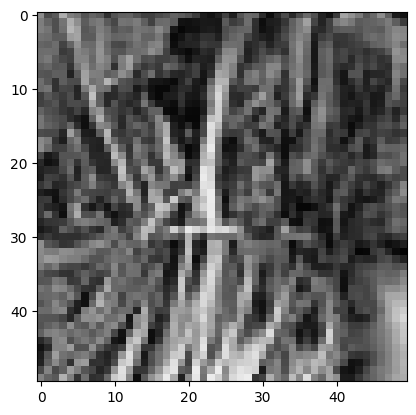

In [15]:
#plt.imshow(tf.image.grayscale_to_rgb(tf.convert_to_tensor(displaySquare(val_img_dataset[0][:, :, None], 100 , 20))))
#plt.show()
plt.imshow(tf.image.grayscale_to_rgb(tf.convert_to_tensor(new_img_dataset[0][:, :, None])))
plt.show()

## Definition of the Model

the latent_dim parameter defines the size of the encoding vector.

In [16]:
batch_size = 16
latent_dim = 32
epoch_num = 5
img_size = 50
dataset_size = len(img_dataset)
train_size = int(dataset_size * 0.9) // batch_size * batch_size
total_size = dataset_size // batch_size * batch_size

In [17]:
class Sampling(nn.Module):
    def forward(self, z_mean, z_log_var):
        batch, dim = z_mean.shape
        epsilon = Normal(0, 1).sample((batch, dim)).to(z_mean.device)
        return z_mean + torch.exp(0.5 * z_log_var) * epsilon

class Encoder(nn.Module):
    def __init__(self, image_size, embedding_dim):
        super(Encoder, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(128, 256, 3, stride=1, padding=1)
        self.flatten = nn.Flatten()
        self.fc_mean = nn.LazyLinear(embedding_dim)
        self.fc_log_var = nn.LazyLinear(embedding_dim)
        self.sampling = Sampling()

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.flatten(x)
        z_mean = self.fc_mean(x)
        z_log_var = self.fc_log_var(x)
        z = self.sampling(z_mean, z_log_var)
        return z_mean, z_log_var, z, x

class Decoder(nn.Module):
    def __init__(self, embedding_dim, shape_before_flattening, full_size):

        super(Decoder, self).__init__()
        self.fc = nn.LazyLinear(full_size)
        self.shape_before_flattening = shape_before_flattening
        self.deconv1 = nn.ConvTranspose2d(256, 128, 3, padding=1, stride=1)
        self.deconv2 = nn.ConvTranspose2d(128, 64, 2, padding=1, stride=2)
        self.deconv3 = nn.ConvTranspose2d(64, 32, 3, padding=1, stride=1)
        self.deconv4 = nn.ConvTranspose2d(32, 1, 3, padding=0, stride=1)

    def forward(self, x):
        x = self.fc(x)
        x = torch.reshape(x, (self.shape_before_flattening))
        x = F.relu(self.deconv1(x))
        x = F.relu(self.deconv2(x))
        x = F.relu(self.deconv3(x))
        x = torch.sigmoid(self.deconv4(x))
        return x

class VAE(nn.Module):
    def __init__(self, encoder, decoder):
        super(VAE, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
    def forward(self, x):
        z_mean, z_log_var, z, _ = self.encoder(x)
        reconstruction = self.decoder(z)
        return [reconstruction, z]

## Visual Representation of the model
Here, for 50 x 50 images

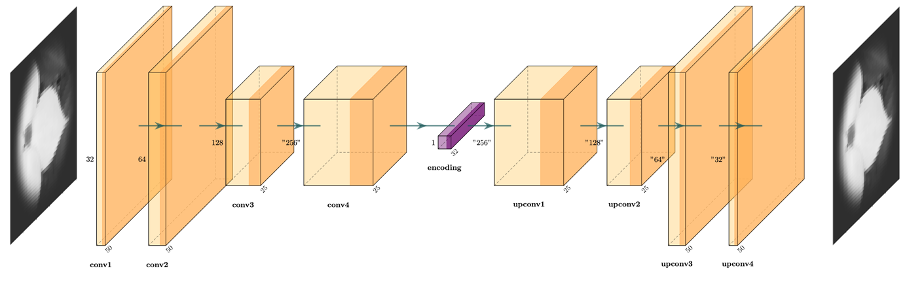

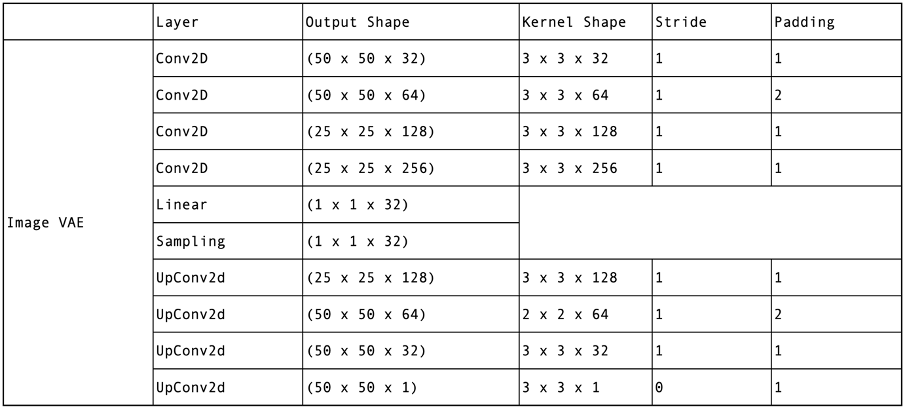

## Training

In [18]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device: ", device)

train_set = new_img_dataset[:train_size]
test_set = new_img_dataset[train_size:total_size]

train_loader = torch.utils.data.DataLoader(
    train_set, batch_size=batch_size, shuffle=True
)

test_loader = torch.utils.data.DataLoader(
    test_set, batch_size=batch_size, shuffle=True
)

shape_before_flattening = batch_size, int(256), int(img_size/2), int(img_size/2)

encoder = Encoder(img_size, latent_dim)
decoder = Decoder(latent_dim,shape_before_flattening, 256*int(img_size/2)*int(img_size/2))
vae = VAE(encoder, decoder).to(device)

optimizer = optim.Adam(list(encoder.parameters()) + list(decoder.parameters()))
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=0.1, verbose=True)

best_val_loss = float("inf")
for epoch in range(epoch_num):
    vae.train()
    running_loss = 0.0
    for batch_idx, data in tqdm(enumerate(train_loader)):
        optimizer.zero_grad()
        data = data[:, None, :, :].float().to(device)
        pred = vae(data)[0].to(device)
        loss = nn.functional.mse_loss(pred, data)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    train_loss = running_loss / len(train_loader)

    running_val_loss = 0.0
    for batch_idx, data in enumerate(test_loader):
        data = data[:, None, :, :].float().to(device)
        pred = vae(data)[0].to(device)
        loss = nn.functional.mse_loss(pred, data)
        running_val_loss += loss.item()

    val_loss = running_val_loss / len(test_loader)

    print(f"Epoch {epoch} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")
    scheduler.step(val_loss)

Device:  cuda


0it [00:00, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
2851it [00:51, 54.93it/s]


Epoch 0 | Train Loss: 0.0124 | Val Loss: 0.0108


2851it [00:51, 55.67it/s]


Epoch 1 | Train Loss: 0.0104 | Val Loss: 0.0103


2851it [00:52, 54.31it/s]


Epoch 2 | Train Loss: 0.0102 | Val Loss: 0.0101


2851it [01:01, 46.02it/s]


Epoch 3 | Train Loss: 0.0101 | Val Loss: 0.0100


2851it [00:51, 54.85it/s]


Epoch 4 | Train Loss: 0.0100 | Val Loss: 0.0099


The following line saves the model

In [19]:
torch.save(vae.state_dict(), '/content/gdrive/My Drive/Image Decoding/50 x 50 material/VAE_50.npy')

## Reconstruction

This block of code is useful for sanity checking, first row of images is the originals, second row is the reconstructions. number is the index of the  image in the validation dataset we want to display first (0 if we just want the first 16 images)

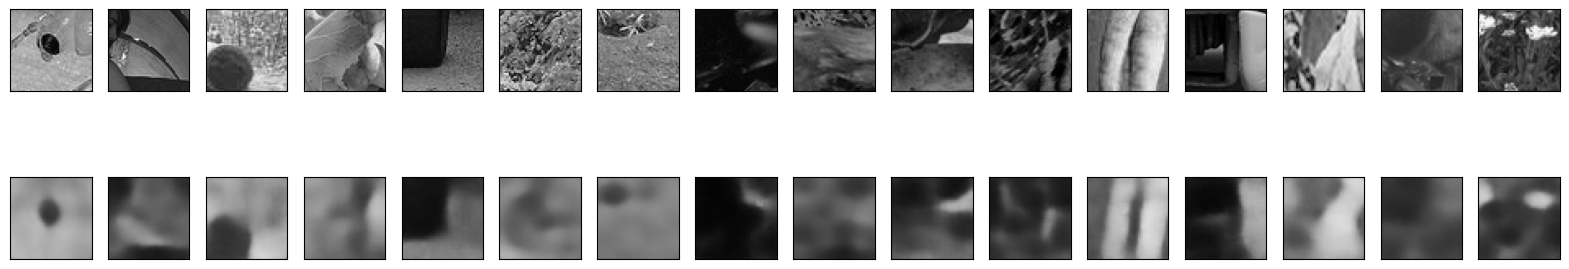

In [21]:
number = 0
examples = torch.from_numpy(new_val_img_dataset[number:number+batch_size]).to(device)
decoded_imgs = vae(examples[:, None, :, :].float())[0].cpu().detach().numpy().squeeze()[:, :, :, None]

plt.figure(figsize=(20, 4))
for i in range(batch_size):
    ax = plt.subplot(2, batch_size, i + 1)
    img = tf.image.grayscale_to_rgb(tf.convert_to_tensor(new_val_img_dataset[number+i][:, :, None]))
    plt.imshow(img)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display the reconstructed image
    ax = plt.subplot(2, batch_size, i + 1 + batch_size)

    plt.imshow(tf.image.grayscale_to_rgb(tf.convert_to_tensor(decoded_imgs[i])))
    # plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

## Encoding

This block is used to encode full datasets using the VAE that was just trained, which is essential to the second part of the experiment: the reconstruction from brain signals directly.

In [22]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device: ", device)

train_set = new_img_dataset[:train_size]
test_set = new_img_dataset[train_size:total_size]

train_loader = torch.utils.data.DataLoader(
    train_set, batch_size=batch_size, shuffle=True
)

test_loader = torch.utils.data.DataLoader(
    test_set, batch_size=batch_size, shuffle=True
)

shape_before_flattening = batch_size, int(256), int(img_size/2), int(img_size/2)

encoder = Encoder(img_size, latent_dim)
decoder = Decoder(latent_dim,shape_before_flattening, 256*int(img_size/2)*int(img_size/2))
vae = VAE(encoder, decoder).to(device)

vae.load_state_dict(torch.load('/content/gdrive/My Drive/Image Decoding/50 x 50 material/VAE_50.npy'))

Device:  cuda


<All keys matched successfully>

In [23]:
no_shuffle_train_loader = torch.utils.data.DataLoader(
    train_set, batch_size=batch_size, shuffle=False
)

encodings = np.zeros((1, 32))
for batch_idx, data in enumerate(no_shuffle_train_loader):
    data = data[:, None, :, :].float().to(device)
    pred = vae(data)[1].cpu().detach().numpy()
    encodings = np.append(encodings, pred, axis=0)
encodings = encodings[1:]

In [24]:
#ENCODING SAVING FILENAME

np.save('/content/gdrive/My Drive/Image Decoding/50 x 50 material/train_encodings_50.npy', encodings)

In [25]:
val_no_shuffle_train_loader = torch.utils.data.DataLoader(
    new_val_img_dataset[:992], batch_size=batch_size, shuffle=False
)

val_encodings = np.zeros((1, 32))
for batch_idx, data in enumerate(val_no_shuffle_train_loader):
    data = data[:, None, :, :].float().to(device)
    pred = vae(data)[1].cpu().detach().numpy()
    val_encodings = np.append(val_encodings, pred, axis=0)
val_encodings = val_encodings[1:]

In [26]:
#VALIDATION ENCODING SAVING FILENAME

np.save('/content/gdrive/My Drive/Image Decoding/50 x 50 material/val_encodings_50.npy', val_encodings)

## Compute VAE SSIM

The following snipped computes the SSIM score and the pixel-to-pixel correlation of the reconstruction.

I recommend using the latter as its results match visual inspection better and are less sensitive to localized noise.

In [27]:
batch_number = len(new_val_img_dataset) // batch_size
avg_ssim = 0
avg_corr = 0

running_val_loss = 0.0
for batch_idx, cur_data in tqdm(enumerate(val_no_shuffle_train_loader)):
    data = cur_data[:, None, :, :].float().to(device)
    pred = vae(data)[0].to(device)
    for j in range(batch_size):
      avg_ssim += ssim(data[j,0].detach().cpu().numpy(), pred[j,0].detach().cpu().numpy(), full=True)[0]
      data[j,0,0] += 0.000001
      avg_corr += np.corrcoef(data[j,0].detach().cpu().numpy().flatten().squeeze(), pred[j,0].detach().cpu().numpy().flatten().squeeze())

print("Average SSIM: ", avg_ssim/float(batch_number * batch_size))
print("Average corr: ", avg_corr[0, 1]/float(batch_number * batch_size))

62it [00:01, 44.94it/s]

Average SSIM:  0.5761345149896533
Average corr:  0.7603487705979413
